# **Stereo Denoising**

In this notebook we will go over a few methods to densoise stereo depth maps. We will use data from the 2021 Middleburry stereo vision dataset located here:
https://vision.middlebury.edu/stereo/data/scenes2021/

In [10]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

In [11]:
data_path = r"C:\Users\itber\Documents\datasets\middlebury_2021_stereo\chess2"

Get images, ground truth disparity and calibration data. Image 0 refers to the left image and image 1 refers to the right image A description of he calibration parameters is shown below:


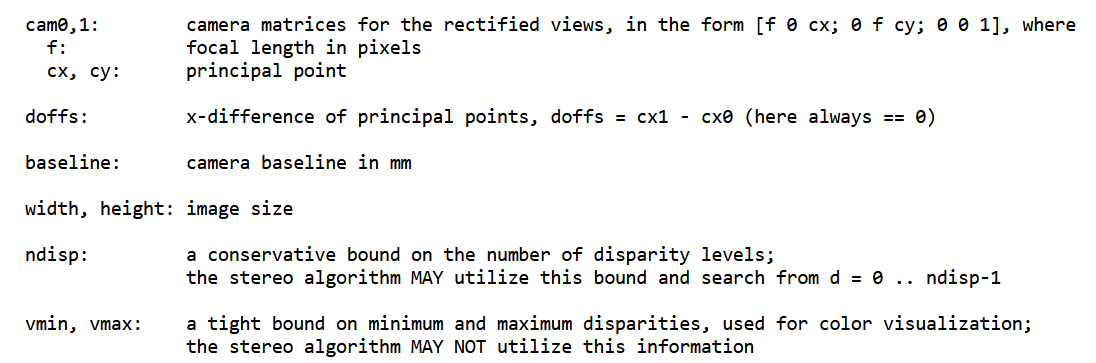


In [12]:
image0_path = os.path.join(data_path, "im0.png")
image1_path = os.path.join(data_path, "im1.png")
disp0_path = os.path.join(data_path, "disp0.pfm")
disp1_path = os.path.join(data_path, "disp1.pfm")

image0 = cv2.cvtColor(cv2.imread(image0_path), cv2.COLOR_BGR2RGB)
image1 = cv2.cvtColor(cv2.imread(image1_path), cv2.COLOR_BGR2RGB)

disparity0 = cv2.cvtColor(cv2.imread(disp0_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
disparity1 = cv2.cvtColor(cv2.imread(disp1_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)


In [13]:
# convert to grayscale 
image0_gray = cv2.cvtColor(image0, cv2.COLOR_RGB2GRAY)
image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)

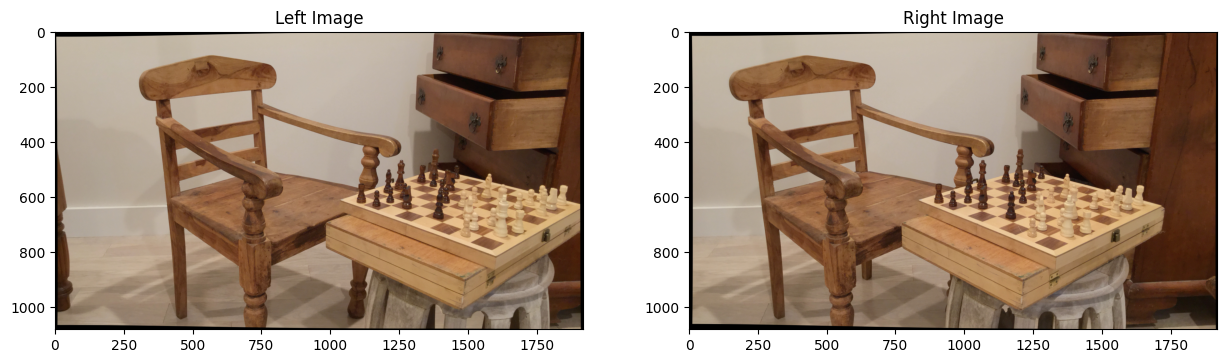

In [14]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(image0)
ax[0].set_title("Left Image")

ax[1].imshow(image1)
ax[1].set_title("Right Image");

In [15]:
def get_plot_disparity(disparity):
    # all channels are the same, get a single channel
    disparity = disparity[:, :, 0]

    # replace infinity with arbirary large value for plotting
    disparity[disparity == np.inf] = disparity[disparity != np.inf].max()*2

    # rescale to 0-1
    disparity = cv2.normalize(disparity, 
                              None, 
                              alpha=0, 
                              beta=1, 
                              norm_type=cv2.NORM_MINMAX, 
                              dtype=cv2.CV_32F)
    
    return disparity
    

In [16]:
# replace infinity with arbirary large value for plotting
disparity0_plot = get_plot_disparity(disparity0)
disparity1_plot = get_plot_disparity(disparity1)

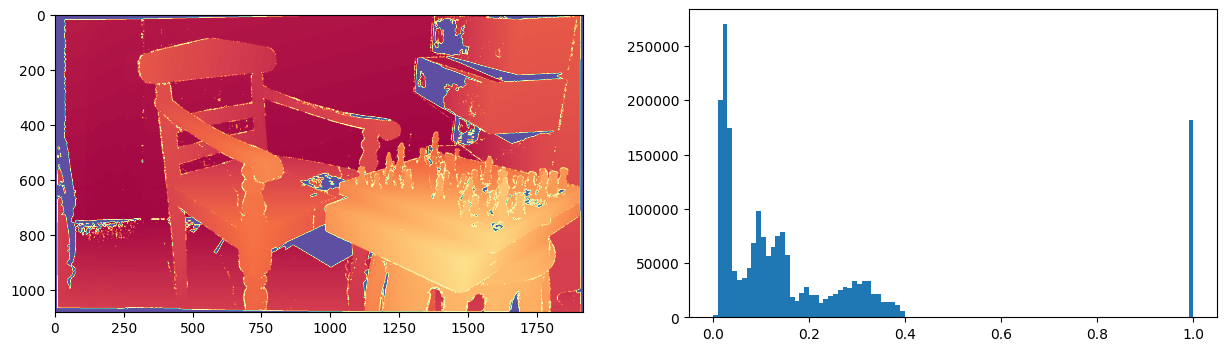

In [20]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(disparity0_plot, cmap="Spectral")
ax[1].hist(disparity0_plot.reshape((-1, 1)), bins=100);

In [18]:
disparity0_plot

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [37]:
import csv
import re

with open(os.path.join(data_path, "calib.txt"), 'r') as fin:
    calib = list(fin)


convert_to_mat = lambda x_in : [float(x) for x in x_in.split(' ') if len(x) > 0]

cam_left_intrinsic = calib[0].split(']')[0].split('[')[-1].strip("").split(';')
cam_right_intrinsic = calib[1].split(']')[0].split('[')[-1].strip("").split(';')
doffs = float(re.search("\d", calib[2]).group())
baseline = float(re.search("\d+\.\d+", calib[3]).group())
width = int(re.search("\d+", calib[4]).group())
height = int(re.search("\d+", calib[5]).group())
ndisp = int(re.search("\d+", calib[6]).group())
vmin = int(re.search("\d+", calib[7]).group())
vmax = int(re.search("\d+", calib[8]).group())

# convert intrinsic matrices to arrays
cam_left_intrinsic = np.array(list(map(convert_to_mat, cam_left_intrinsic)))
cam_right_intrinsic = np.array(list(map(convert_to_mat, cam_right_intrinsic)))

In [38]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16, 
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs: 
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images
        
        NOTE: image_left must be the left image (same for the right) or 
              unexpected results will occur due to 
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size, 
        P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    # compute disparity
    disparity = sgbm_obj.compute(left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
      plt.figure(figsize = (40,20))
      plt.imshow(disparity, cmap='cividis')
      plt.title('Disparity Map', size=25)
      plt.show();

    return disparity
     


In [39]:
image0_gray = cv2.cvtColor(image0, cv2.COLOR_RGB2GRAY)
image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)

image0_gray = cv2.normalize(image0_gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
image1_gray = cv2.normalize(image1_gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [137]:
ndisp

310

In [143]:
16*16

256

In [150]:
disparity = compute_sgbm_disparity(image0, image1, num_disparities=16*16, 
                                   block_size=7, window_size=5, display=False)

disparity = cv2.normalize(disparity, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

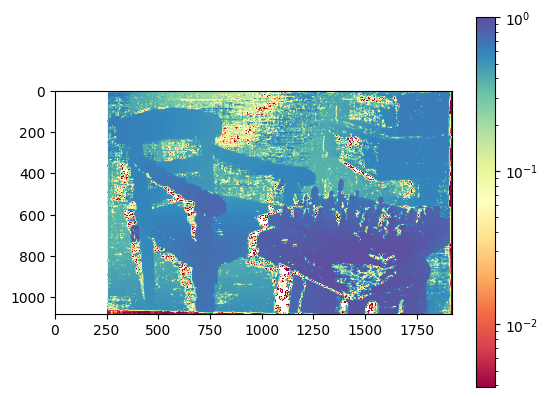

In [151]:
plt.imshow(disparity, cmap="Spectral", norm=colors.LogNorm())
plt.colorbar();

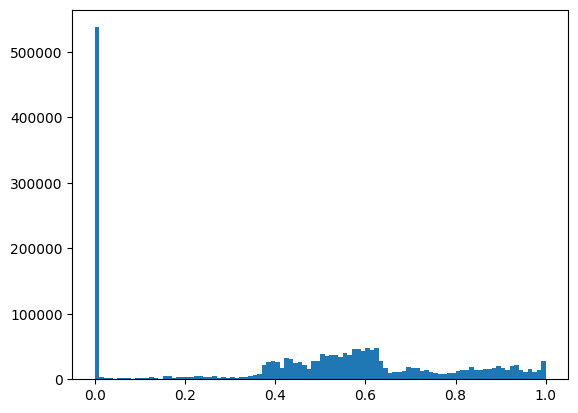

In [152]:
plt.hist(disparity.reshape((-1, 1)), bins=100);

Filter Disparity map with Normalized Averaging

First we need to find the certainty. We will come up with a more automated method later, for now we will just set all values below a certain threshold to be uncertain

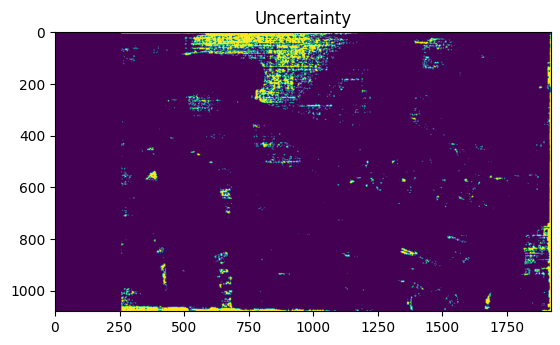

In [155]:
uncertainty = (disparity != 0) & (disparity < 0.3)
plt.imshow(uncertainty)
plt.title("Uncertainty")

certainty = ~uncertainty

Get Applicability Kernels

In [156]:
# applicability kernel functions
appl_fun = np.vectorize(lambda x: 0.5*x**(-3) if ((abs(x) > 1) and (abs(x) < 10)) else 1) # local Kernel
appl_fun_gaus = np.vectorize(lambda x, sig=1.2: (1/(sig*2*np.pi))*np.exp((-x**2)/(2*sig))) # Gaussian Kernel


def cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True):
    complex_format = x - x_c + 1j * (y - y_c)
    return np.abs(complex_format), np.angle(complex_format, deg = deg)

n = 11
x, y = np.mgrid[-(n-1)//2:(n+1)//2, -(n-1)//2:(n+1)//2]
rho, theta = cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True)

# Applicability Kernels
a = appl_fun(rho)
a_gaus = appl_fun_gaus(rho)

Convolve Normalized Disparity with Applicability Kernels

In [157]:
af = cv2.filter2D(src=disparity, ddepth=-1, kernel=a)
af_gaus = cv2.filter2D(src=disparity, ddepth=-1, kernel=a_gaus)

Convolve the certainty with the Applicability Kernels to get the divisor

In [158]:
certainty_norm = cv2.normalize(certainty.astype(int), None, alpha=0.12, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
ca = cv2.filter2D(src=certainty_norm , ddepth=-1, kernel=a)
ca_gaus = cv2.filter2D(src=certainty_norm , ddepth=-1, kernel=a_gaus)

Perform Normalized Averaging

In [159]:
na = af/ca
na_gaus = af_gaus/ca_gaus

In [160]:
na_gaus = cv2.normalize(na_gaus, None, alpha=0.12, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
na = cv2.normalize(na, None, alpha=0.12, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

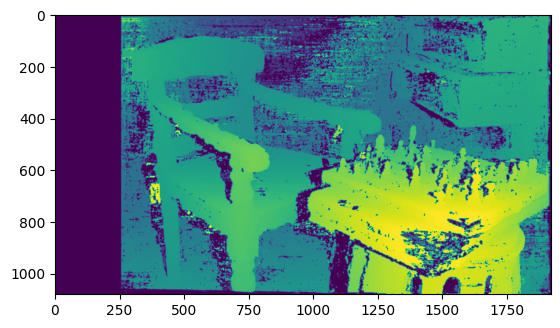

In [161]:
plt.imshow(af)

In [162]:
na_gaus.max()

1.0

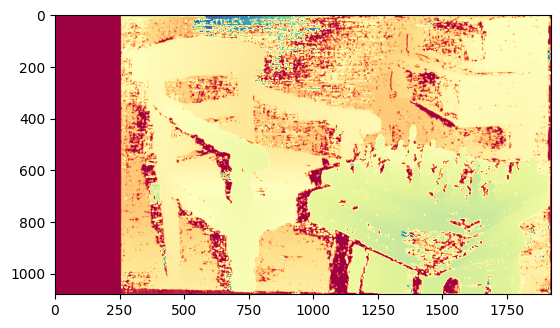

In [163]:
plt.imshow(na_gaus, cmap="Spectral", norm=colors.LogNorm())

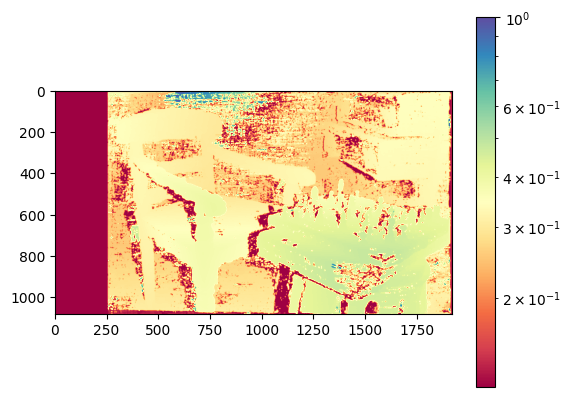

In [164]:
plt.imshow(na, cmap="Spectral", norm=colors.LogNorm())
plt.colorbar();

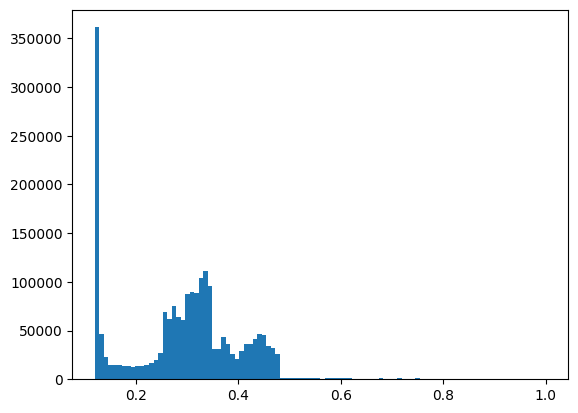

In [165]:
plt.hist(na.reshape((-1, 1)), bins=100);